In [15]:
# Task 1.
# Текстурные характеристики:
#  - Реализуйте подсчет гистограммы 
#  - Реализуйте рассчет текстурных характеристик Laws 
#  - Реализуйте расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM
# Для каждого случая: выполните тренировку классификатора (knn, svm, trees)
# Решите задачу сегментации данных на основе классификации изображений каждым методом.
# Выполните ручную разметку изображений на регионы.
# Сравните результат полученной классификации и размеченной.

In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from skimage.feature import graycomatrix, graycoprops
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, jaccard_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import clone

In [50]:
DATASET_PATH = r"C:\Users\smeta\Downloads\kth_tips_grey_200x200\KTH_TIPS"

def extract_histogram_features(image, bins=256):
    hist = cv2.calcHist([image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    hist = hist / (hist.sum() + 1e-6)
    values = np.arange(bins)
    features = {}
    features['mean'] = np.sum(hist * values)
    variance = np.sum(hist * (values - features['mean'])**2)
    features['std'] = np.sqrt(variance)
    if features['std'] > 0:
        features['skewness'] = np.sum(hist * ((values - features['mean']) / features['std'])**3)
    else:
        features['skewness'] = 0
    if features['std'] > 0:
        features['kurtosis'] = np.sum(hist * ((values - features['mean']) / features['std'])**4) - 3
    else:
        features['kurtosis'] = -3
    non_zero_probs = hist[hist > 0]
    features['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    cumulative_hist = np.cumsum(hist)
    features['q1'] = np.argmax(cumulative_hist >= 0.25)
    features['q2'] = np.argmax(cumulative_hist >= 0.5)
    features['q3'] = np.argmax(cumulative_hist >= 0.75)
    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features['min'] = non_zero_bins[0]
        features['max'] = non_zero_bins[-1]
    else:
        features['min'] = 0
        features['max'] = 255
    feat_array = np.array([features['mean'], features['std'], features['skewness'], 
                          features['kurtosis'], features['entropy'], 
                          features['q1'], features['q2'], features['q3'], 
                          features['min'], features['max']])
    return feat_array

In [51]:
def extract_laws_features(image):
    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    masks_1d = [L5, E5, S5, W5, R5]
    filters_2d = []
    for mask1 in masks_1d:
        for mask2 in masks_1d:
            kernel = np.outer(mask1, mask2)
            filters_2d.append(kernel)
    features = []
    for kernel in filters_2d:
        filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
        energy = np.mean(filtered ** 2)
        features.append(energy)
    features = np.array(features)
    if np.sum(features) > 0:
        features = features / np.sum(features)
    return features

In [52]:
def extract_glcm_features(image):
    image = (image // 8).astype(np.uint8)
    glcm = graycomatrix(image, distances=[1], 
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        levels=32, symmetric=True, normed=True)
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        feature_val = np.mean(graycoprops(glcm, prop))
        features.append(feature_val)
    return np.array(features)

In [53]:
def extract_features(image, method='hist'):
    if method == 'hist':
        return extract_histogram_features(image)
    elif method == 'laws':
        return extract_laws_features(image)
    elif method == 'glcm':
        return extract_glcm_features(image)

In [54]:
def load_dataset(dataset_path, feature_method, resize_to=(128, 128)):
    data = []
    labels = []
    classes = sorted([d for d in os.listdir(dataset_path) 
                      if os.path.isdir(os.path.join(dataset_path, d))])
    print(f"Найденные классы: {classes}")
    print(f"Извлечение признаков [{feature_method}]...")
    total_images = 0
    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for filename in image_files:
            img_path = os.path.join(class_dir, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
                    features = extract_features(img, method=feature_method)
                    data.append(features)
                    labels.append(class_name)
                    total_images += 1
            except:
                pass
    print(f"Загружено: {total_images} изображений\n")
    return np.array(data), np.array(labels)

In [55]:
def train_and_evaluate_models(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    classifiers = {
        'kNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
    }
    
    trained_models = {}
    results = {}
    
    print("Обучение классификаторов:")
    print("-" * 60)
    
    for clf_name, clf_instance in classifiers.items():
        clf = clone(clf_instance)
        if clf_name == 'SVM':
            clf.fit(X_train, y_train_encoded)
            y_pred = clf.predict(X_test)
            trained_models[clf_name] = (clf, scaler)
        else:
            clf.fit(X_train, y_train_encoded)
            y_pred = clf.predict(X_test)
            trained_models[clf_name] = clf
        
        accuracy = accuracy_score(y_test_encoded, y_pred)
        print(f"{clf_name:15} | Accuracy: {accuracy:.1%} | Train: {len(X_train)}, Test: {len(X_test)}")
        
        results[clf_name] = {
            'y_true': y_test_encoded,
            'y_pred': y_pred,
            'y_names': y_test
        }
    
    return trained_models, results, le.classes_, scaler, le

In [56]:
def print_results(y_true, y_pred, class_names, clf_name, feature_method):
    print(f"\n{'='*60}")
    print(f"РЕЗУЛЬТАТЫ: {feature_method.upper()} + {clf_name}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [57]:
def segment_sandwich(model_info, full_image, scaler, le, feature_method, patch_size=32, step=4):
    h, w = full_image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)
    all_predictions = []
    
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = full_image[y:y + patch_size, x:x + patch_size]
            features = extract_features(patch, method=feature_method)
            if isinstance(model_info, tuple):
                model, scaler_obj = model_info
                features_scaled = scaler_obj.transform(features.reshape(1, -1))
                pred_class = model.predict(features_scaled)[0]
            else:
                model = model_info
                pred_class = model.predict(features.reshape(1, -1))[0]
            
            seg_map[y:y + patch_size, x:x + patch_size] = pred_class
            all_predictions.append(pred_class)
    
    unique, counts = np.unique(all_predictions, return_counts=True)
    top_classes = unique[np.argsort(counts)[-4:]]
    
    seg_map_filtered = np.zeros_like(seg_map)
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i
    
    print(f"Уникальные классы после фильтрации: {np.unique(seg_map_filtered)}")
    return seg_map_filtered

In [58]:
def keep_top_colors(mask, n_colors=4):
    unique, counts = np.unique(mask, return_counts=True)
    sorted_indices = np.argsort(-counts)
    top_colors = unique[sorted_indices[:n_colors]]
    
    print(f"Топ-{n_colors} самых частых цветов: {top_colors}")
    print(f"Их частоты: {counts[sorted_indices[:n_colors]]}")
    
    result = np.zeros_like(mask)
    for new_value, old_value in enumerate(top_colors):
        result[mask == old_value] = new_value
    
    print(f"Перенумеровано: {top_colors} -> {list(range(len(top_colors)))}\n")
    return result

In [59]:
def find_best_permutation(manual_mask, predicted_mask):
    manual_classes = sorted(np.unique(manual_mask))
    pred_classes = sorted(np.unique(predicted_mask))
    
    if len(pred_classes) < len(manual_classes):
        pred_classes = list(pred_classes) + [255] * (len(manual_classes) - len(pred_classes))
    
    best_accuracy = 0
    best_mapping = {}
    
    for perm in permutations(pred_classes[:len(manual_classes)]):
        temp_mask = predicted_mask.copy()
        for manual_cls, pred_cls in zip(manual_classes, perm):
            if pred_cls != 255:
                temp_mask[predicted_mask == pred_cls] = manual_cls
        
        accuracy = accuracy_score(manual_mask.flatten(), temp_mask.flatten())
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = dict(zip(manual_classes, perm))
    
    return best_mapping, best_accuracy

In [60]:
def compare_segmentation_optimized(manual_mask, predicted_mask, original_img, model_name):
    if manual_mask is None or predicted_mask is None:
        print("Одна из масок равна None!")
        return None
    
    if manual_mask.shape != predicted_mask.shape:
        predicted_mask = cv2.resize(predicted_mask, 
                                   (manual_mask.shape[1], manual_mask.shape[0]),
                                   interpolation=cv2.INTER_NEAREST)
    
    manual_classes = np.unique(manual_mask)
    pred_classes = np.unique(predicted_mask)
    
    print(f"Классы в ручной разметке: {manual_classes}")
    print(f"Классы в предсказании: {pred_classes}")
    
    best_mapping, best_accuracy = find_best_permutation(manual_mask, predicted_mask)
    
    pred_mapped = predicted_mask.copy()
    for manual_cls, pred_cls in best_mapping.items():
        if pred_cls != 255:
            pred_mapped[predicted_mask == pred_cls] = manual_cls
    
    print(f"\nОптимальное переназначение классов:")
    for manual_cls, pred_cls in best_mapping.items():
        print(f"   Предсказание класс {pred_cls} → Ручная разметка класс {manual_cls}")
    
    print(f"\nТочность: {best_accuracy:.1%}")
    print(f"IoU по классам:")
    
    for class_id in manual_classes:
        try:
            iou = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(), 
                              average=None, labels=[class_id])[0]
            print(f"   Класс {class_id}: {iou:.3f}")
        except:
            print(f"   Класс {class_id}: 0.000")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')
    
    axes[1].imshow(manual_mask, cmap='tab10')
    axes[1].set_title('Ручная разметка')
    axes[1].axis('off')
    
    axes[2].imshow(pred_mapped, cmap='tab10')
    axes[2].set_title(f'Предсказание {model_name}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return best_accuracy

In [61]:
print("Histogram - извлечение и обучение")

X_hist, y_hist = load_dataset(DATASET_PATH, 'hist')
print(f"Размер данных: X={X_hist.shape}, y={y_hist.shape}\n")

hist_models, hist_results, hist_classes, hist_scaler, hist_le = train_and_evaluate_models(X_hist, y_hist)

for clf_name, result in hist_results.items():
    print_results(result['y_true'], result['y_pred'], hist_classes, clf_name, 'hist')

Histogram - извлечение и обучение
Найденные классы: ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker', 'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam']
Извлечение признаков [hist]...
Загружено: 810 изображений

Размер данных: X=(810, 10), y=(810,)

Обучение классификаторов:
------------------------------------------------------------
kNN             | Accuracy: 83.7% | Train: 607, Test: 203
SVM             | Accuracy: 84.7% | Train: 607, Test: 203
DecisionTree    | Accuracy: 83.7% | Train: 607, Test: 203

РЕЗУЛЬТАТЫ: HIST + kNN
                precision    recall  f1-score   support

aluminium_foil       1.00      1.00      1.00        20
   brown_bread       0.95      0.95      0.95        20
      corduroy       0.62      0.80      0.70        20
        cotton       0.71      0.57      0.63        21
       cracker       0.95      0.90      0.93        21
         linen       0.74      0.70      0.72        20
   orange_peel       0.90      0.90      0.90 

In [62]:
print("Law - извлечение и обучение")

X_laws, y_laws = load_dataset(DATASET_PATH, 'laws')
print(f"Размер данных: X={X_laws.shape}, y={y_laws.shape}\n")

laws_models, laws_results, laws_classes, laws_scaler, laws_le = train_and_evaluate_models(X_laws, y_laws)

for clf_name, result in laws_results.items():
    print_results(result['y_true'], result['y_pred'], laws_classes, clf_name, 'laws')

Law - извлечение и обучение
Найденные классы: ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker', 'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam']
Извлечение признаков [laws]...
Загружено: 810 изображений

Размер данных: X=(810, 25), y=(810,)

Обучение классификаторов:
------------------------------------------------------------
kNN             | Accuracy: 81.3% | Train: 607, Test: 203
SVM             | Accuracy: 57.6% | Train: 607, Test: 203
DecisionTree    | Accuracy: 72.9% | Train: 607, Test: 203

РЕЗУЛЬТАТЫ: LAWS + kNN
                precision    recall  f1-score   support

aluminium_foil       1.00      1.00      1.00        20
   brown_bread       0.69      0.90      0.78        20
      corduroy       0.78      0.70      0.74        20
        cotton       1.00      0.71      0.83        21
       cracker       0.73      0.90      0.81        21
         linen       1.00      0.80      0.89        20
   orange_peel       0.81      0.81      0.81       

In [63]:
print("GLCM - извлечение и обучение")

X_glcm, y_glcm = load_dataset(DATASET_PATH, 'glcm')
print(f"Размер данных: X={X_glcm.shape}, y={y_glcm.shape}\n")

glcm_models, glcm_results, glcm_classes, glcm_scaler, glcm_le = train_and_evaluate_models(X_glcm, y_glcm)

for clf_name, result in glcm_results.items():
    print_results(result['y_true'], result['y_pred'], glcm_classes, clf_name, 'glcm')

GLCM - извлечение и обучение
Найденные классы: ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker', 'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam']
Извлечение признаков [glcm]...
Загружено: 810 изображений

Размер данных: X=(810, 5), y=(810,)

Обучение классификаторов:
------------------------------------------------------------
kNN             | Accuracy: 61.6% | Train: 607, Test: 203
SVM             | Accuracy: 54.7% | Train: 607, Test: 203
DecisionTree    | Accuracy: 49.3% | Train: 607, Test: 203

РЕЗУЛЬТАТЫ: GLCM + kNN
                precision    recall  f1-score   support

aluminium_foil       1.00      1.00      1.00        20
   brown_bread       0.52      0.65      0.58        20
      corduroy       0.57      0.40      0.47        20
        cotton       0.47      0.33      0.39        21
       cracker       0.60      0.86      0.71        21
         linen       0.56      0.50      0.53        20
   orange_peel       0.77      0.81      0.79       

In [64]:
print("Создание коллажа:")
classes = sorted([d for d in os.listdir(DATASET_PATH) 
                  if os.path.isdir(os.path.join(DATASET_PATH, d))])[:4]
print(f"Используемые классы: {classes}\n")

images = []
for class_name in classes:
    class_dir = os.path.join(DATASET_PATH, class_name)
    image_files = [f for f in os.listdir(class_dir) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        img_path = os.path.join(class_dir, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (100, 100))
            images.append(img)

top = np.hstack([images[0], images[1]])
bottom = np.hstack([images[2], images[3]])
collage = np.vstack([top, bottom])
cv2.imwrite("test_image.png", collage)
print(f" Коллаж создан: test_image.png (200×200 пикселей)")
print(f"   Каждый регион: 100×100 пикселей\n")
original_img = collage.copy()

Создание коллажа:
Используемые классы: ['aluminium_foil', 'brown_bread', 'corduroy', 'cotton']

 Коллаж создан: test_image.png (200×200 пикселей)
   Каждый регион: 100×100 пикселей



Обработка ручной разметки:
Топ-4 самых частых цветов: [ 50 200 100 150]
Их частоты: [10000 10000  9999  9996]
Перенумеровано: [ 50 200 100 150] -> [0, 1, 2, 3]


Сегментация: Histogram_kNN

Уникальные классы после фильтрации: [0]

Классы в ручной разметке: [0 1 2 3]
Классы в предсказании: [0]

Оптимальное переназначение классов:
   Предсказание класс 0 → Ручная разметка класс 0
   Предсказание класс 255 → Ручная разметка класс 1
   Предсказание класс 255 → Ручная разметка класс 2
   Предсказание класс 255 → Ручная разметка класс 3

Точность: 25.0%
IoU по классам:
   Класс 0: 0.250
   Класс 1: 0.000
   Класс 2: 0.000
   Класс 3: 0.000


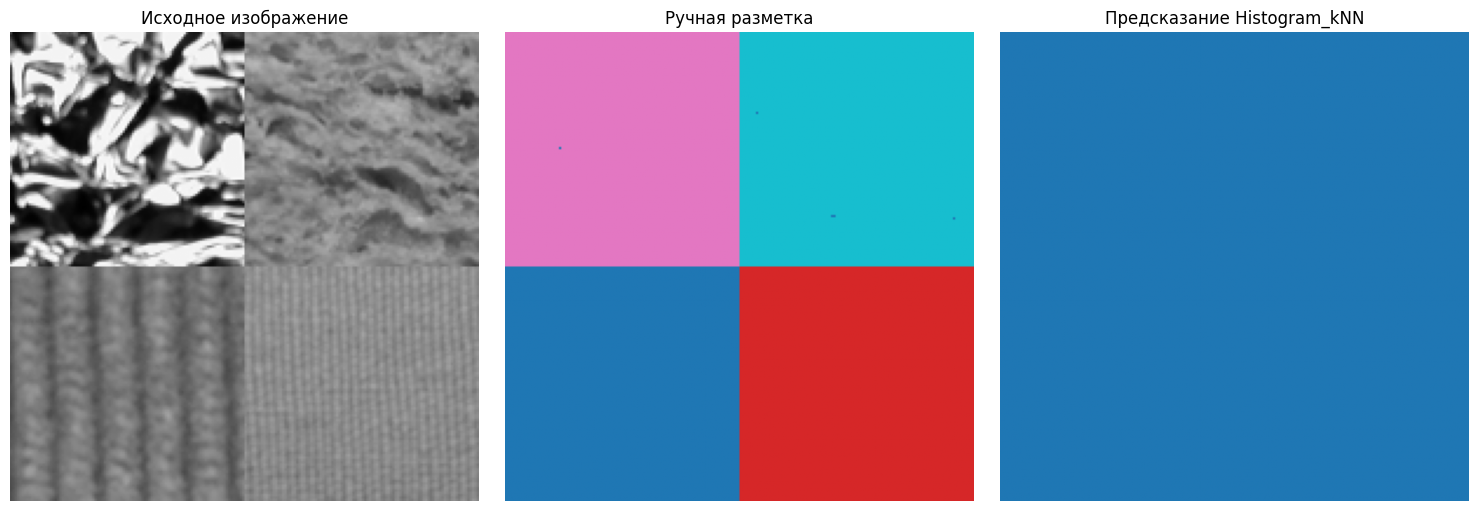


 Итоговая точность: 25.0%


Сегментация: Laws_SVM

Уникальные классы после фильтрации: [0 1 2 3]

Классы в ручной разметке: [0 1 2 3]
Классы в предсказании: [0 1 2 3]

Оптимальное переназначение классов:
   Предсказание класс 3 → Ручная разметка класс 0
   Предсказание класс 0 → Ручная разметка класс 1
   Предсказание класс 2 → Ручная разметка класс 2
   Предсказание класс 1 → Ручная разметка класс 3

Точность: 43.0%
IoU по классам:
   Класс 0: 0.330
   Класс 1: 0.000
   Класс 2: 0.722
   Класс 3: 0.000


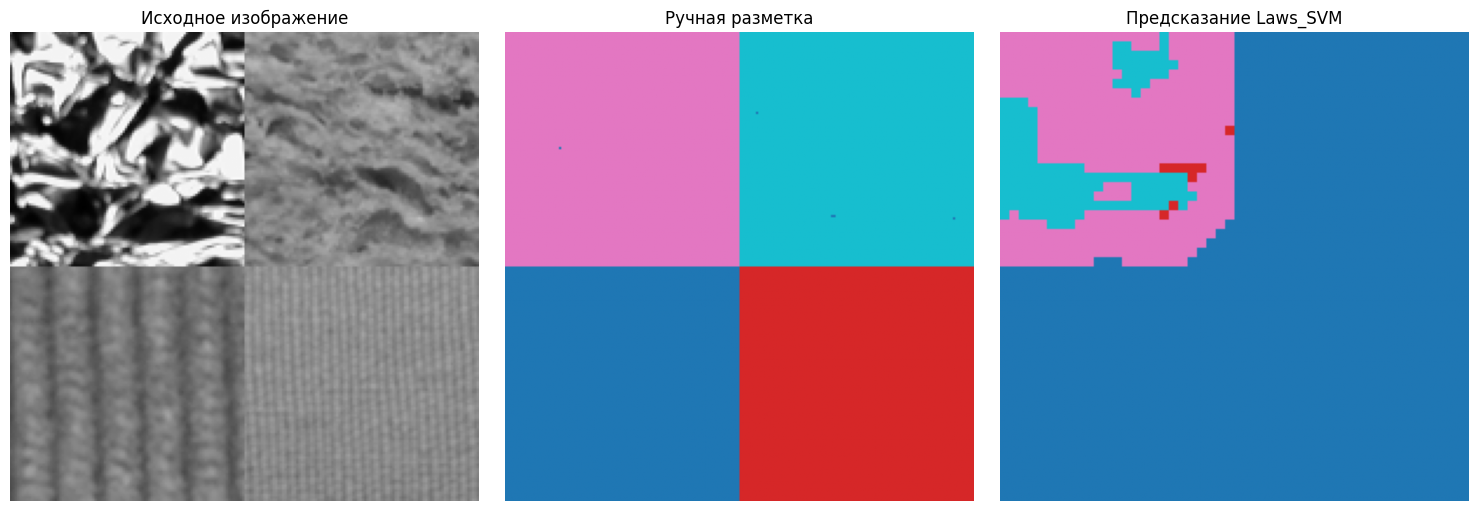


 Итоговая точность: 43.0%


Сегментация: GLCM_DecisionTree

Уникальные классы после фильтрации: [0 1 2]

Классы в ручной разметке: [0 1 2 3]
Классы в предсказании: [0 1 2]

Оптимальное переназначение классов:
   Предсказание класс 1 → Ручная разметка класс 0
   Предсказание класс 0 → Ручная разметка класс 1
   Предсказание класс 2 → Ручная разметка класс 2
   Предсказание класс 255 → Ручная разметка класс 3

Точность: 62.5%
IoU по классам:
   Класс 0: 0.834
   Класс 1: 0.603
   Класс 2: 0.412
   Класс 3: 0.000


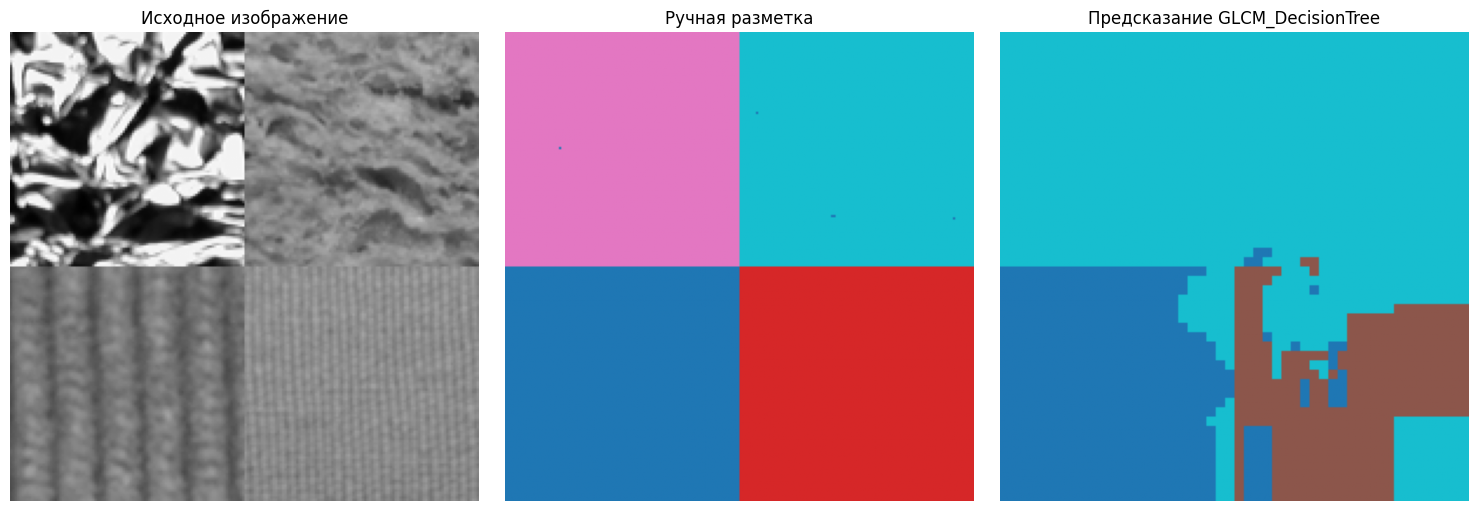


 Итоговая точность: 62.5%



In [65]:
manual_mask = cv2.imread("test_image_manual.png", cv2.IMREAD_GRAYSCALE)
print("Обработка ручной разметки:")
fixed_manual_mask = keep_top_colors(manual_mask, n_colors=4)

selected_models = {
    'Histogram_kNN': ('hist', 'kNN', hist_models, hist_scaler, hist_le),
    'Laws_SVM': ('laws', 'SVM', laws_models, laws_scaler, laws_le),
    'GLCM_DecisionTree': ('glcm', 'DecisionTree', glcm_models, glcm_scaler, glcm_le)
}

results_summary = {}

for model_name, (f_method, clf_name, models, scaler, le) in selected_models.items():
    print(f"\n{'='*70}")
    print(f"Сегментация: {model_name}")
    print(f"{'='*70}\n")
    
    model_info = models[clf_name]
    predicted_mask = segment_sandwich(model_info, original_img, scaler, le, f_method, patch_size=32, step=4)
    
    print()
    accuracy = compare_segmentation_optimized(fixed_manual_mask, predicted_mask, original_img, model_name)
    
    if accuracy:
        results_summary[model_name] = accuracy*100
        print(f"\n Итоговая точность: {accuracy*100:.1f}%\n")

In [66]:
print("Итоговая сводка результатов:")

for model_name, accuracy in results_summary.items():
    print(f"{model_name:30} Точность: {accuracy:6.1f}%")

Итоговая сводка результатов:
Histogram_kNN                  Точность:   25.0%
Laws_SVM                       Точность:   43.0%
GLCM_DecisionTree              Точность:   62.5%
